# Install dependencies and load the dataset

In [1]:
!pip install -r ../requirements.txt

In [2]:
import pandas as pd
import numpy as np

data = pd.read_csv('../data/penguins.csv')

data.head()


,culmen_length_mm,culmen_depth_mm,flipper_length_mm,body_mass_g,sex
0,39.1,18.7,181.0,3750.0,MALE
1,39.5,17.4,186.0,3800.0,FEMALE
2,40.3,18.0,195.0,3250.0,FEMALE
3,NaN,NaN,NaN,NaN,NaN
4,36.7,19.3,193.0,3450.0,FEMALE


# Quick EDA

As I have done that on KNN notebook, I will skip this part short here

In [3]:
data['sex'] = data['sex'].replace('.', np.nan)
data['sex'] = data['sex'].str.upper().str.strip()
data = data.dropna(subset=['sex'])
data = data.reset_index(drop=True)

feature_cols = ['culmen_length_mm', 'culmen_depth_mm', 'flipper_length_mm', 'body_mass_g']

data[feature_cols] = data[feature_cols].astype(float)

print("\nMissing values in feature columns:")
print(data[feature_cols].isnull().sum())

data = data.dropna(subset=feature_cols)
data = data.reset_index(drop=True)

data['sex'] = data['sex'].map({'MALE': 1, 'FEMALE': 0})

from sklearn.preprocessing import StandardScaler

X = data[feature_cols]
y_true = data['sex'].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Missing values in feature columns:
culmen_length_mm     0
culmen_depth_mm      0
flipper_length_mm    0
body_mass_g          0
dtype: int64


# Load the model and train

In [4]:
import sys
import os

notebook_dir = os.path.dirname(os.path.abspath("__file__"))
sys.path.append(os.path.join(notebook_dir, '..'))
from src import KMeansClustering

In [5]:
num_clusters = 5

kmeans = KMeansClustering(K=num_clusters)
kmeans.fit(X_scaled)

cluster_assignments = kmeans.predict(X_scaled)

print("\nCluster Centroids:")
print(kmeans.centroids)


Converged at iteration 5

Cluster Centroids:
[[ 1.05491504 -0.72970091  0.0278908   1.62809008]
 [-1.11229004  0.2207441  -0.10236258 -1.01064706]
 [ 0.27807683 -1.46194915 -0.0051179   0.60314515]
 [-0.65240434  1.08885937  0.19627025 -0.10990719]
 [ 0.99059388  0.7004016  -0.0676444  -0.53093013]]


# Result and Evaluation

In [6]:
from sklearn.metrics import adjusted_rand_score, silhouette_score

ari_score = adjusted_rand_score(y_true, cluster_assignments)
print(f"\nAdjusted Rand Index (ARI): {ari_score:.4f}")



Adjusted Rand Index (ARI): 0.2298


In [7]:
sil_score = silhouette_score(X_scaled, cluster_assignments)
print(f"Silhouette Score: {sil_score:.4f}")


Silhouette Score: 0.4031


Quick evaluation:
- With the intention of clustering the dataset into 5 clusters, the K-Means did not perform well in this case. While it found some structure in the data, the clusters do not align well with the true labels. 
    - This might due to several reasons, such as overlapping feature distributions , the presence of noise in the data or the K-Means algorithm itself, etc.

Let's do the last visualization on the dataset to see if my assumption is correct or not

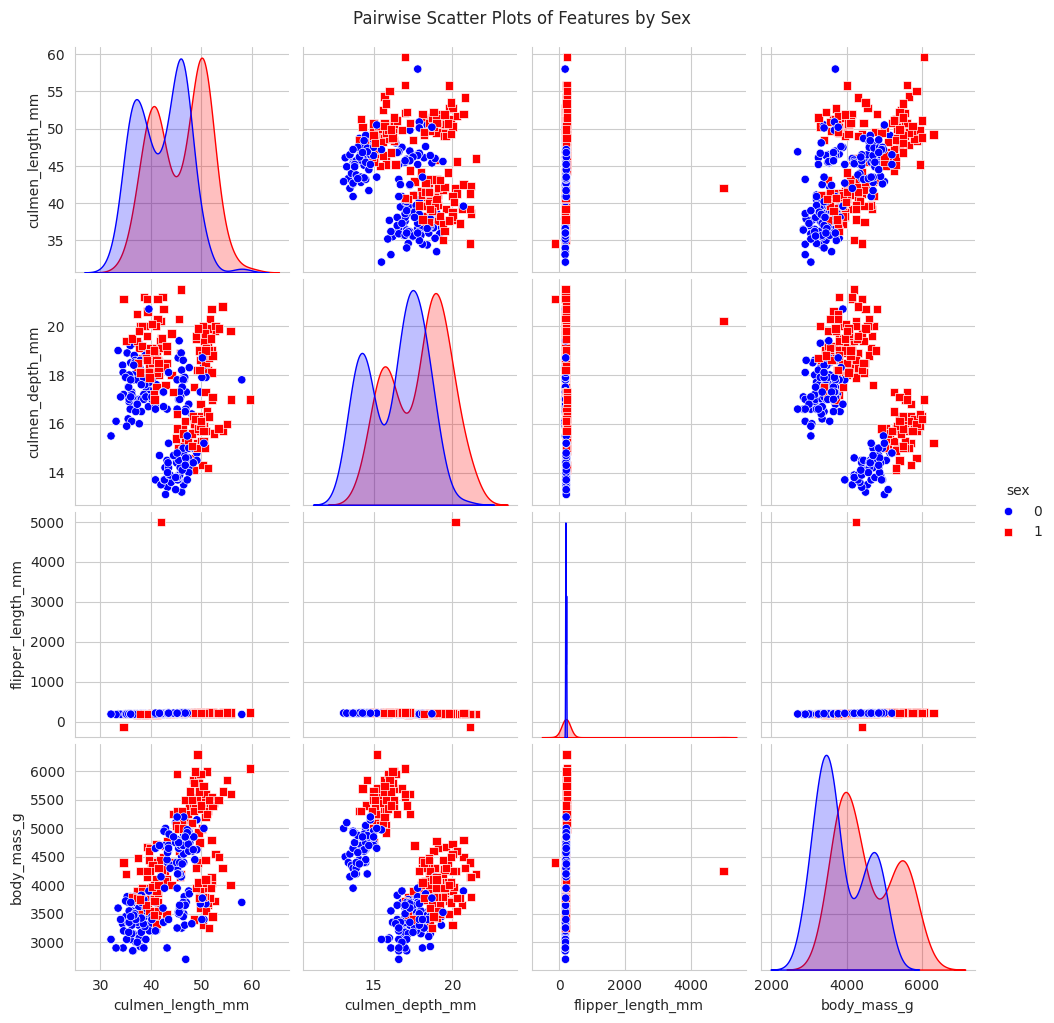

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns
    
sns.pairplot(data, vars=feature_cols, hue='sex', palette=['blue', 'red'], markers=["o", "s"])
plt.suptitle('Pairwise Scatter Plots of Features by Sex', y=1.02)
plt.show()



This indicates that I need to do some more EDA, feature engineering or feature selection to improve the clustering performance.

# Visualization

IndexError: list index out of range

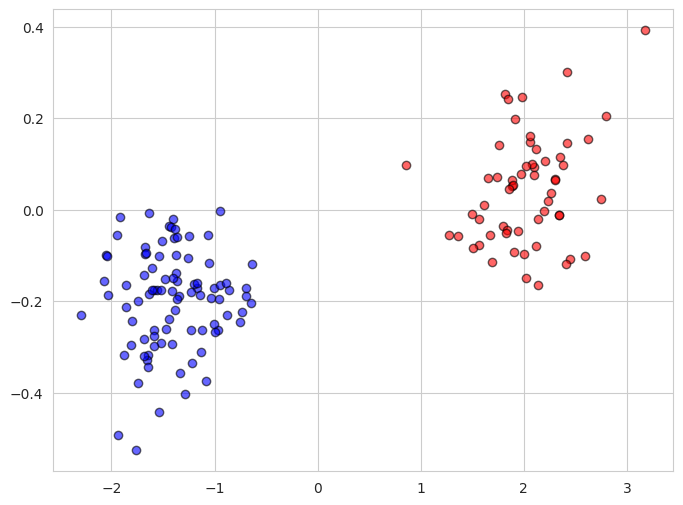

In [9]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

plt.figure(figsize=(8, 6))
colors = ['red', 'blue']
cluster_labels = ['Cluster 1', 'Cluster 2']

for k in range(num_clusters):
    cluster_data = X_pca[cluster_assignments == k]
    plt.scatter(cluster_data[:, 0], cluster_data[:, 1], c=colors[k], label=cluster_labels[k], alpha=0.6, edgecolor='k')

plt.title('K-Means Clustering of Penguins (PCA Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()


In [ ]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(y_true, cluster_assignments)

conf_df = pd.DataFrame(conf_matrix, index=['FEMALE', 'MALE'], columns=['Cluster 1', 'Cluster 2'])

print("\nContingency Table:")
print(conf_df)

plt.figure(figsize=(6, 4))
sns.heatmap(conf_df, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix between True Labels and Cluster Assignments')
plt.ylabel('True Label')
plt.xlabel('Cluster Assignment')
plt.show()